In [261]:
import os
import numpy as np
import pandas as pd
import re
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer


from nltk.tokenize.toktok import ToktokTokenizer

from simpletransformers.classification import ClassificationModel

from wordcloud import WordCloud,STOPWORDS
import re,string,unicodedata

from sklearn.model_selection import train_test_split
import transformers

# Подготовим данные

In [33]:
# import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt')
# nltk.download('stopwords')

In [34]:
data=pd.read_csv('IMDB Dataset.csv')
data.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

### Удалим дубликаты

In [36]:
data.describe() 

review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

In [37]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [38]:
data.duplicated().sum()

418

In [39]:
data.drop_duplicates(inplace = True)

In [40]:
data.duplicated().sum()

0

### Очистим текст и лемматизируем

In [41]:
def replacing_tags(x):
    for tag in re.findall(r'<.*?>', x):
        x = x.replace(tag, '')
    return x

In [42]:
 def emoji_cleaning(x):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    x = emoji_clean.sub(r'', x)
    return x

In [43]:
def mapping(x):
    
    mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
           "'cause": "because", "could've": "could have", "couldn't": "could not", 
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
           "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
           "she's": "she is", "should've": "should have", "shouldn't": "should not", 
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
           "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
           "here's": "here is","they'd": "they would", "they'd've": "they would have", 
           "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
           "we're": "we are", "we've": "we have", "weren't": "were not", 
           "what'll": "what will", "what'll've": "what will have","what're": "what are",  
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
           "you're": "you are", "you've": "you have" }
    
    for key in mapping.keys():
        if key in x:
            x = x.replace(key, mapping[key])
    return x

In [44]:
def removing_punctuation(x):
     return "".join([letter.lower() for letter in x if letter not in string.punctuation]).replace('  ', ' ')

In [45]:
stop = stopwords.words('english')
def lemmatize(x):
    wl = WordNetLemmatizer()
    x = " ".join([wl.lemmatize(word) for word in x.split() if word not in stop and word.isalpha()])
    return x

In [46]:
def clear_data(x):
    x = replacing_tags(x)
    x = emoji_cleaning(x)
    x = mapping(x)
    x = removing_punctuation(x)
    x = lemmatize(x)
    return x

In [47]:
%%time
data.review = data['review'].apply(clear_data) # Очистим данные

CPU times: user 1min 16s, sys: 266 ms, total: 1min 16s
Wall time: 1min 16s


### Закодируем сентимент

In [48]:
data.sentiment = [1 if sent == "positive" else 0 for sent in data.sentiment]

In [51]:
# data_copy = data.copy()

### Проведем обучение модели

"Хочу купить мощную видеокарту, и собрать ПК, чтобы обучать нейронки" не прокатило. Поэтому.

Модель отдельно обучал в колабе, и потом выгружал.

In [50]:
data.to_pickle('Prepared_imdb_data.pkl')

In [74]:
data_copy = pd.read_pickle('Prepared_imdb_data.pkl')

In [75]:
data_copy.to_csv('prepared_imdb.csv')

In [56]:
model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "max_seq_length": 512,
    "train_batch_size": 16,
    "num_train_epochs": 4,
}

# Create a ClassificationModel
model = ClassificationModel('bert', 'bert-base-cased', num_labels=2, args=model_args,
                            use_cuda=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [54]:
train_df, eval_df = train_test_split(data_copy, test_size=0.2, random_state=42)

In [88]:
# model.train_model(train_df[["review", "sentiment"]]) # обучен в колабе. На моем компе прогноз около 200 часов.


In [87]:
model = ClassificationModel('bert', 'outputs/', use_cuda=False)

loading configuration file outputs/config.json
Model config BertConfig {
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file outputs/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at outputs/.
If your task is similar to the task the model of the checkpoint was trained o

In [94]:
predictions, raw_outputs = model.predict(['Some arbitary sentence', 'Bad boy', 'nice job'])


  0%|          | 0/3 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1 [00:00<?, ?it/s]

In [95]:
predictions

[1, 0, 1]

In [96]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df[["review", "sentiment"]])
print(result)

/Users/alex/opt/anaconda3/envs/st/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/9917 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running Evaluation:   0%|          | 0/1240 [00:00<?, ?it/s]

{'mcc': 0.8238029879569704, 'tp': 4511, 'tn': 4532, 'fp': 407, 'fn': 467, 'auroc': 0.9685054409476611, 'auprc': 0.9671768575385471, 'eval_loss': 0.43988526917211507}


In [104]:
# eval_res = {'mcc': 0.8238029879569704, 'tp': 4511, 'tn': 4532, 'fp': 407, 'fn': 467, 'auroc': 0.9685054409476611, 
#  'auprc': 0.9671768575385471, 'eval_loss': 0.43988526917211507}
# 5 часов заняла валидация датасета на CPU
#MCC(Коэффициент корреляции Мэтьюса)
# он колеблется между -1 и 1, где 1 балл показывает идеальное предсказание, 0 равно случайному предсказанию, 
#                       а -1 обозначает полное несоответствие между прогнозируемыми баллами и значениями истинных меток.

In [99]:
eval_df

review  sentiment
29171  soul plane horrible attempt comedy appeal peop...          0
43589  guest future tell fascinating story time trave...          1
38712  national treasure thoroughly misguided hodgepo...          0
16045  ok first said wanted check whether movie avera...          0
5248   always fan show grew season started see richne...          1
...                                                  ...        ...
2923   kennedymiller could hardly done better job tac...          1
15292  disney studio remake slapstick classic concern...          0
17849  gave star possible went realizing discovered a...          0
38079  found tremendously disappointing version charm...          0
2691   manmohan desai made entertaining though illogi...          0

[9917 rows x 2 columns]

### Теперь сделаем предсказание по фильмам

In [ ]:
ex_df = pd.read_csv('extended_dataset.csv')

In [ ]:
ex_df.dropna(subset=['Plot',], inplace=True) # выкинем все, что без описания и обновим индексы
ex_df.reset_index(drop=True, inplace=True)

In [ ]:
for_pred = ex_df['Plot'].apply(clear_data)

In [ ]:
predictions, raw_outputs = model.predict(for_pred)


In [ ]:
ex_df['Predicted_sentiment'] = predictions

In [ ]:
ex_df.to_csv('with_sentiment.csv')

### Загрузим датасет на ПК

In [101]:
sent_df = pd.read_csv('with_sentiment.csv')

In [108]:
sent_df.drop(['Unnamed: 0.1','Unnamed: 0'], axis=1, inplace=True)

In [120]:
sent_df.head() # получили датасет с предсказанным сентиментом

Release Year                             Title Origin/Ethnicity  \
0        1901.0            Kansas Saloon Smashers         American   
1        1901.0     Love by the Light of the Moon         American   
2        1901.0           The Martyred Presidents         American   
3        1901.0  Terrible Teddy, the Grizzly King         American   
4        1902.0            Jack and the Beanstalk         American   

                             Director Cast Genre  \
0                                 NaN  NaN   NaN   
1                                 NaN  NaN   NaN   
2                                 NaN  NaN   NaN   
3                                 NaN  NaN   NaN   
4  George S. Fleming, Edwin S. Porter  NaN   NaN   

                                                 Url  \
0  https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...   
1  https://en.wikipedia.org/wiki/Love_by_the_Ligh...   
2  https://en.wikipedia.org/wiki/The_Martyred_Pre...   
3  https://en.wikipedia.org/wiki/Terrible_Teddy,_...   
4  https://en.wikipedia.org/wiki/Jack_and_the_Bea...   

                                                Plot  Predicted_sentiment  
0  A bartender is working at a saloon, serving dr...                    0  
1  The moon, painted with a smiling face hangs ov...                    0  
2  The film, just over a minute long, is composed...                    1  
3  Lasting just 61 seconds and consisting of two ...                    1  
4  The earliest known adaptation of the classic f...                    1

### Теперь проведем аналитику по полученным данным

In [140]:
sent_df.Genre.nunique()
df = sent_df.copy()

In [181]:
def replacing_film(x):
    if type(x) == str:
        return x.replace('film', '').lower().strip() # уберем слово "фильм", а также приведем всё к одному регистру.
df['Genre'] = df['Genre'].apply(replacing_film)

df.replace('unknown', np.nan, inplace=True) #Немного причешем датасет
df.replace('Unknown', np.nan, inplace=True)

df.dropna(subset=['Plot',], inplace=True) # выкинем все, что без описания и обновим индексы
df.reset_index(drop=True, inplace=True)


df['Genre'] = df['Genre'].apply(lambda x: x.replace('sci-fi', 'science fiction').replace('science-fiction', 'science fiction') if x != None else None)

comedy_pattern = r'.*comedy.*'
drama_pattern = r'.*drama.*'
war_pattern = r'.*war.*'
thriller_pattern = r'.*thriller.*'

df['Genre'] = df['Genre'].apply(lambda x: x.replace(re.search(comedy_pattern, x).group(), 'comedy') 
                                if len(re.findall(comedy_pattern, str(x))) != 0 else x)
df['Genre'] = df['Genre'].apply(lambda x: x.replace(re.search(drama_pattern, x).group(), 'drama') 
                                if len(re.findall(drama_pattern, str(x))) != 0 else x)
df['Genre'] = df['Genre'].apply(lambda x: x.replace(re.search(war_pattern, x).group(), 'war') 
                                if len(re.findall(war_pattern, str(x))) != 0 else x)
df['Genre'] = df['Genre'].apply(lambda x: x.replace(re.search(thriller_pattern, x).group(), 'thriller') 
                                if len(re.findall(thriller_pattern, str(x))) != 0 else x)


most_freq_genres = df["Genre"].value_counts()
top25_genres = tuple(most_freq_genres[:25].index)
def regenrator(x): 
    '''Выцепим все самые популярные жанры из оставшихся записей'''
    if x is None:
        return np.nan
    if x in top25_genres:
        return x
    else:
        for i in top25_genres:
            if str(i) in str(x):
                return i
    return x


df["Genre"] = df['Genre'].apply(regenrator)

most_freq_genres = df["Genre"].value_counts()
top20_genres = tuple(most_freq_genres[:20].index)

def top_20_genres(x):
    'Оставим только 20 самых популярных жанров, остальное - nan'
    if x in top20_genres:
        return x
    else:
        return np.nan
df["Genre"] = df['Genre'].apply(top_20_genres)
df.dropna(subset=['Genre'], inplace=True) # выкинем все, что без описания и обновим индексы
df.reset_index(drop=True, inplace=True)


df ['Origin/Ethnicity'] = df['Origin/Ethnicity'].apply(lambda x: str(x.split(';')[0].split(',')[0]))
# df['Origin/Ethnicity'].unique() #Вычистим непонятные значения.

In [142]:
df.Predicted_sentiment = df.Predicted_sentiment.apply(str).apply(lambda x: x.replace('1', 'positive').replace('0', 'negative'))

In [175]:
df.head()

Release Year                                              Title  \
0        1903.0                            The Great Train Robbery   
1        1904.0                                    The Suburbanite   
2        1906.0  From Leadville to Aspen: A Hold-Up in the Rockies   
3        1907.0                    How Brown Saw the Baseball Game   
4        1907.0                                       Laughing Gas   

  Origin/Ethnicity                                  Director  \
0         American                           Edwin S. Porter   
1         American                        Wallace McCutcheon   
2         American  Francis J. Marion and Wallace McCutcheon   
3         American                                       NaN   
4         American                      Edwin Stanton Porter   

                              Cast    Genre  \
0                              NaN  western   
1                              NaN   comedy   
2                              NaN   action   
3                              NaN   comedy   
4  Bertha Regustus, Edward Boulden   comedy   

                                                 Url  \
0  https://en.wikipedia.org/wiki/The_Great_Train_...   
1      https://en.wikipedia.org/wiki/The_Suburbanite   
2  https://en.wikipedia.org/wiki/From_Leadville_t...   
3  https://en.wikipedia.org/wiki/How_Brown_Saw_th...   
4  https://en.wikipedia.org/wiki/Laughing_Gas_(fi...   

                                                Plot Predicted_sentiment  
0  The film opens with two bandits breaking into ...            positive  
1  The film is about a family who move to the sub...            positive  
2  The film features a train traveling through th...            positive  
3  Before heading out to a baseball game at a nea...            negative  
4  The plot is that of a black woman going to the...            negative

In [243]:
# px.histogram(df, y='Genre',  color='Predicted_sentiment')

fig = px.histogram(df, y='Genre', height=600,
                   title='Количество фильмов по 20 популярным жанрам с разбивкой по сентименту', color='Predicted_sentiment'
                  )
fig.update_yaxes(categoryorder='total ascending')

In [221]:
# Возьмем топ 15 стран.

top15_origins = tuple(df['Origin/Ethnicity'].value_counts()[:15].index)

In [228]:
filt = df['Origin/Ethnicity'].apply(lambda x: x in top15_origins and x != 'English') # сделаем небольшой фильтр

In [230]:
# px.histogram(df, y='Genre',  color='Predicted_sentiment')

fig = px.histogram(df[filt], y='Origin/Ethnicity', height=600,
                   title='Распределение количества фильмов по странам с сегментацией по сентименту', 
                   color='Predicted_sentiment', log_x=False
                  )
fig.update_yaxes(categoryorder='total ascending')

### Сделаем рассчет относительных значений доли позитивных описаний

In [187]:
pos_neg_genres = df.groupby('Predicted_sentiment')['Genre'].value_counts()
pos_rate_by_genre = pos_neg_genres['positive']/(pos_neg_genres['negative']+pos_neg_genres['positive'])

In [189]:

fig = px.histogram(x=pos_rate_by_genre.values, y=pos_rate_by_genre.index, height=600,
                   title='Доля позитивных описаний по жанрам',
                   labels=dict(x = 'Доля позитивных описаний', y = 'Жанр')
                  )
fig.update_yaxes(categoryorder='total ascending')

In [232]:
pos_neg_origins = df[filt].groupby('Predicted_sentiment')['Origin/Ethnicity'].value_counts()
pos_rate_origins = pos_neg_origins['positive']/(pos_neg_origins['negative']+pos_neg_origins['positive'])

In [234]:
pos_rate_origins

Origin/Ethnicity
American      0.684029
Australian    0.761792
Bengali       0.869231
Bollywood     0.846082
British       0.694961
Canadian      0.739385
Chinese       0.815900
Hong Kong     0.758537
Japanese      0.718805
Kannada       0.879808
Malayalam     0.892368
Russian       0.783784
Tamil         0.841965
Telugu        0.863750
Name: Origin/Ethnicity, dtype: float64

In [236]:
fig = px.histogram(x=pos_rate_origins.values, y=pos_rate_origins.index, height=600,
                   title='Доля позитивных описаний по странам',
                   labels=dict(x = 'Доля позитивных описаний', y = 'Страна')
                  )
fig.update_yaxes(categoryorder='total ascending')

### А также проведем исследование по году выпуска фильма

In [242]:
df['Release Year'] = df['Release Year'].apply(int)

In [247]:

fig = px.histogram(df, x='Release Year', height=600,
                   title='Количество фильмов по годам выпуска с разбивкой по сентименту', color='Predicted_sentiment'
                  )
fig.update_yaxes(categoryorder='total ascending')
# С первого взгляда, пропорции плюс-минус идут ровно. Посмотрим, что будет просиходить в относительных величинах.

In [248]:
pos_neg_years = df.groupby('Predicted_sentiment')['Release Year'].value_counts()
pos_rate_by_year = pos_neg_years['positive']/(pos_neg_years['negative']+pos_neg_years['positive'])

In [254]:
fig = px.histogram(y=pos_rate_by_year.values, x=pos_rate_by_year.index, height=600,
                   title='Доля позитивных описаний по странам',
                   labels=dict(x = 'Год', y = 'Доля позитивных описаний'), nbins=130
                   
                  )

fig.update_layout(bargap=0.05)
fig.update_yaxes(categoryorder='total ascending')
# И в целом, так и есть. Сентимент немного просел в середине 20 века и потом понемногу поднимался.

### Ну и в окончание, посмотрим, что покажет wordcloud по разным сентиментам. 

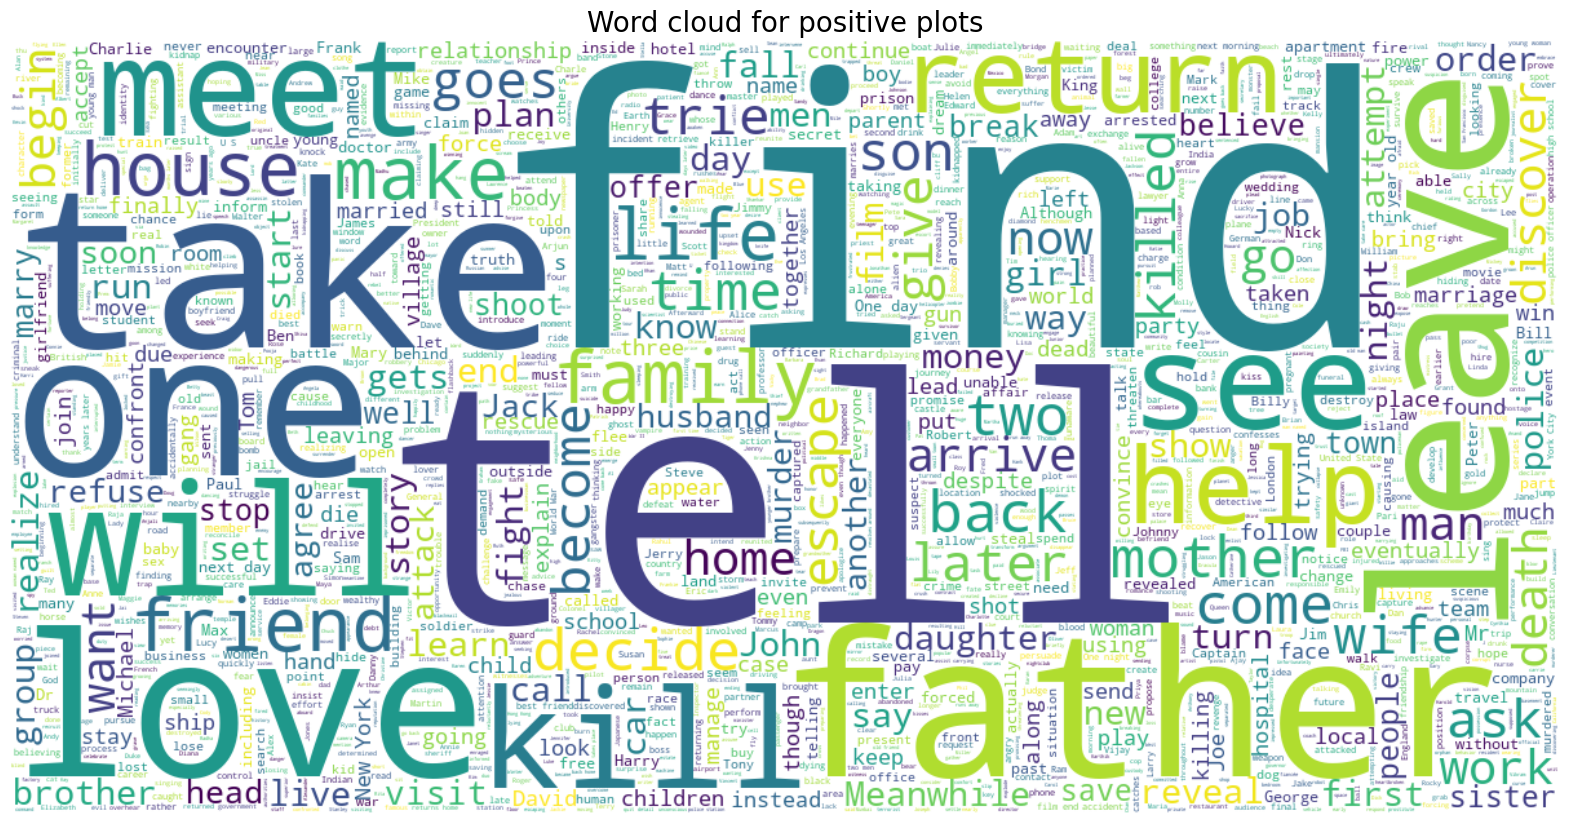

In [263]:
positive_data = df[df.Predicted_sentiment == 'positive']['Plot']
positive_data_string = ' '.join(positive_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(positive_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for positive plots',fontsize = 20)
plt.show()

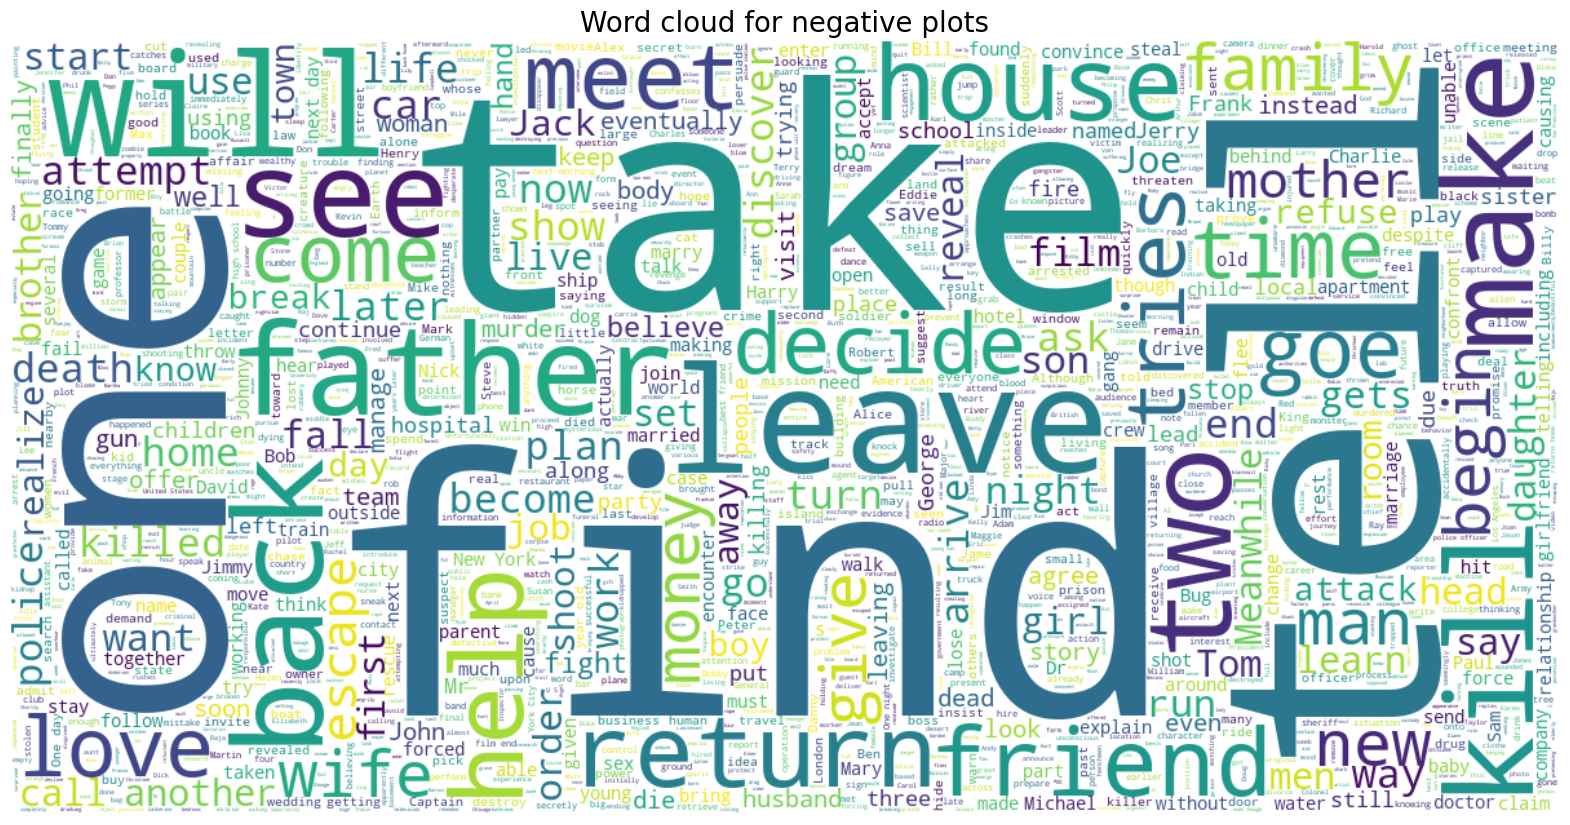

In [269]:
negative_data = df[df.Predicted_sentiment == 'negative']['Plot']
negative_data_string = ' '.join(negative_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for negative plots',fontsize = 20)
plt.show()

In [270]:
# Что интересно, так это то, что многие слова из разных предсказанных сентиментов достаточно схожи.